
# The impact of CEO turnover on company culture

### William Zhu (wzhu4@uchicago.edu)



## Table of contents
0. Importing packages
1. Importing and exploring Glassdoor Corpora
    
    (1a) overview of corpora
    
    (1b) topic clustering
    
2. Divergence Heatmap
    
3. Changes in 9 values by year

4. Projections over keywords

5. Prediction via classification

This file (final_1.ipynb) covers section 1.

## 0. Importing packages

In [18]:
#Special module written for content analysis
import lucem_illud #pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics

import scipy #For hierarchical clustering and some visuals
#import scipy.cluster.hierarchy
import gensim#For topic modeling
import numpy as np #for arrays
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
plt.style.use('fivethirtyeight')
import matplotlib.cm #Still for graphics
import matplotlib.patches as mpatches
import seaborn as sns #Makes the graphics look nicer
import spacy
import nltk

#%matplotlib inline

import itertools
import json

## 1. Importing data

In [19]:
df = pandas.read_csv('combined.csv', index_col=0)
df = df.fillna(' ')

#combine 3 columns of text into one
df['text'] = df['summary'] + ' ' + df['positives'] + ' ' + df['negatives'] + ' ' + df['advice_to_mgmt']

#extract year variable
df['year'] = df['date'].apply(lambda x: x[-4:])

#change the name of the company to category
df['category'] = df['Place']

#only keep 3 columns
df = df[['text', 'category', 'year']]

#category name
dfCategories = ['amazon', 'netflix', 'google', 'apple','facebook', 'microsoft']
dic = {'amazon':0, 'netflix':1, 'google':2, 'apple':3,'facebook':4, 'microsoft':5}

#category id
df['cat_id'] = df['category'].map(dic)

In [20]:
#drop observations with year == none and year == 0000
df = df[df['year']!= 'None']
df = df[df['year'] != '0000']
df = df.reset_index()

In [21]:
df['tokenized_text'] = df['text'].apply(lambda x: lucem_illud.word_tokenize(x))
df['normalized_tokens'] = df['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

In [4]:
df.head()

,ID,text,category,year,cat_id
0,1,Best Company to work for People are smart and ...,google,2018,2
1,2,"Moving at the speed of light, burn out is inev...",google,2013,2
2,3,Great balance between big-company security and...,google,2014,2
3,4,The best place I've worked and also the most d...,google,2015,2
4,10,Execellent for engineers Impact driven. Best t...,google,2018,2


In [10]:
df.to_csv('clean_df.csv')

### (1a) overview of corpora

In [6]:
df['category'].value_counts()

amazon       23990
microsoft    15428
apple        11451
google        6570
facebook      1511
netflix        654
Name: category, dtype: int64

<BarContainer object of 6 artists>

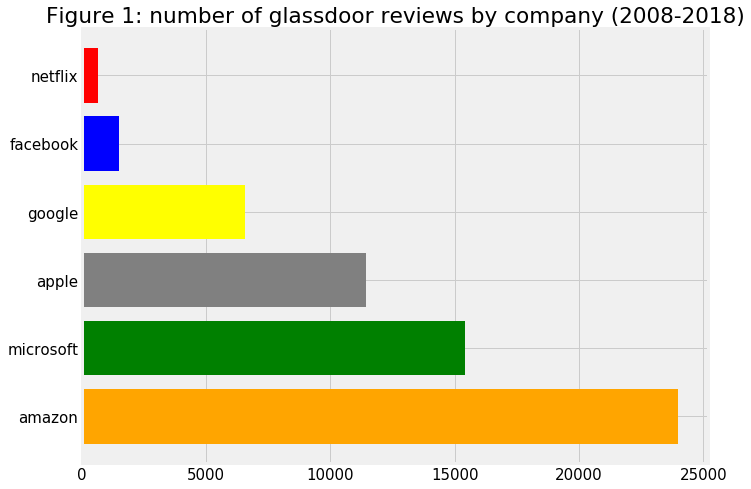

In [8]:
fig = plt.figure(figsize = (10,8))
plt.rc('font', size=15)
plt.title('Figure 1: number of glassdoor reviews by company (2008-2018)') 
comp = df['category'].value_counts()
plt.barh(comp.index, comp.values, color = ['orange', 'green', 'gray', 'yellow', 'blue', 'red'])


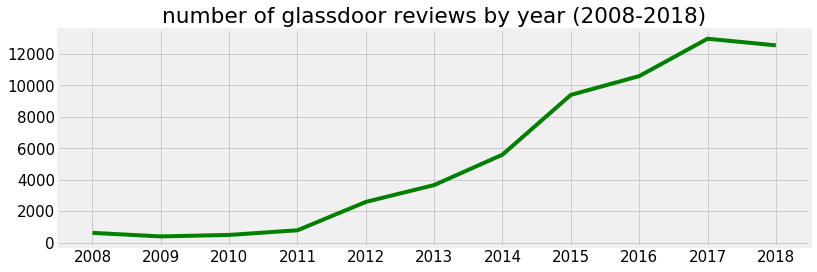

In [8]:
fig = plt.figure(figsize = (12,4))
plt.rc('font', size=15)
comp = df['year'].value_counts().sort_index()
plt.title('number of glassdoor reviews by year (2008-2018)') 
plt.plot(comp, color ='green')

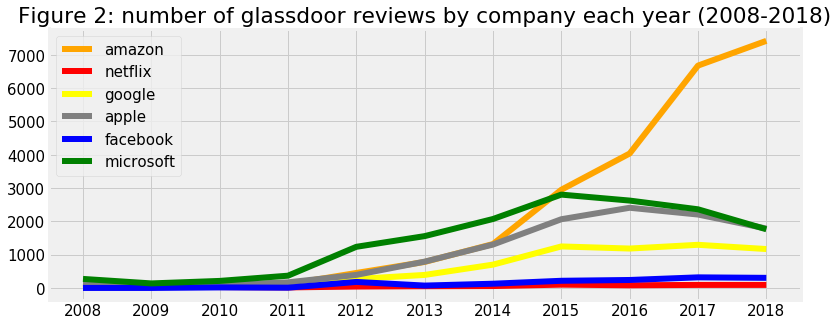

In [9]:
fig = plt.figure(figsize = (12,5))
plt.rc('font', size=15)

comp0 = df[df['cat_id']==0]['year'].value_counts().sort_index()
comp1 = df[df['cat_id']==1]['year'].value_counts().sort_index()
comp2 = df[df['cat_id']==2]['year'].value_counts().sort_index()
comp3 = df[df['cat_id']==3]['year'].value_counts().sort_index()
comp4 = df[df['cat_id']==4]['year'].value_counts().sort_index()
comp5 = df[df['cat_id']==5]['year'].value_counts().sort_index()

plt.title('Figure 2: number of glassdoor reviews by company each year (2008-2018)') 
plt.plot(comp0, color ='orange', label = 'amazon', linewidth=6)
plt.plot(comp1, color ='red', label = 'netflix', linewidth=6)
plt.plot(comp2, color ='yellow', label = 'google', linewidth=6)
plt.plot(comp3, color ='gray', label = 'apple', linewidth=6)
plt.plot(comp4, color ='blue', label = 'facebook', linewidth=6)
plt.plot(comp5, color ='green', label = 'microsoft', linewidth=6)

plt.legend()
plt.show()
 

### (1b) Vectorizing keywords and PCA

Applying word vectors and PCA to see how the reviews of the six companies differ in terms of keywords

In [10]:
#randomly sample 500 reviews from each company
df2 = df.groupby('category').apply(lambda x: x.sample(500, random_state = 123)).reset_index(drop=True)

In [11]:
#First it needs to be initialized
ngCountVectorizer = sklearn.feature_extraction.text.CountVectorizer()
#Then trained
dfVects = ngCountVectorizer.fit_transform(df2['text'])

#initialize
dfTFTransformer = sklearn.feature_extraction.text.TfidfTransformer().fit(dfVects)
#train
dfTF = dfTFTransformer.transform(dfVects)

#initialize
ngTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.1, max_features=800, min_df=10, stop_words='english', norm='l2')
#train
dfTFVects = ngTFVectorizer.fit_transform(df2['text'])

In [12]:
numClusters = len(set(df2['category']))
#k-means++ is a better way of finding the starting points
#We could also try providing our own
km = sklearn.cluster.KMeans(n_clusters=numClusters, init='k-means++', random_state=123)
km.fit(dfTFVects)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=123, tol=0.0001, verbose=0)

In [13]:
terms = ngTFVectorizer.get_feature_names()
order_centroids = km.cluster_centers_.argsort()[:, ::-1]

In [14]:
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 2).fit(dfTFVects.toarray())
reduced_data = pca.transform(dfTFVects.toarray())

In [15]:
components = pca.components_
keyword_ids = list(set(order_centroids[:,:6].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
words = [terms[i] for i in keyword_ids]#Turn the ids into words.
x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
y = components[:,keyword_ids][1,:]

In [16]:
colordict = {
'netflix': 'red',
'amazon': 'orange',
'microsoft': 'green',
'facebook': 'blue',
'google' : 'yellow',
'apple' : 'gray'
    }
colors = [colordict[c] for c in df2['category']]

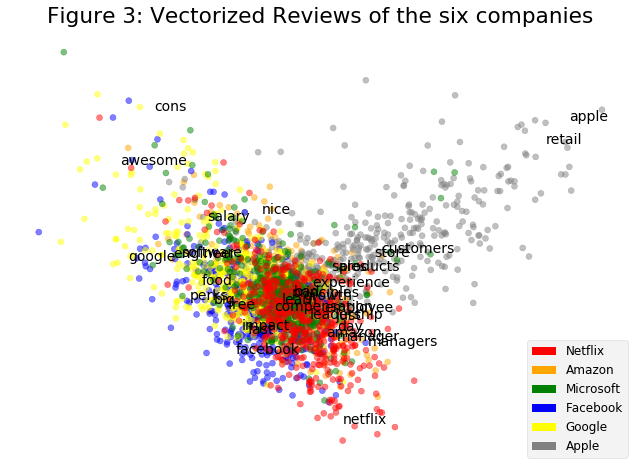

In [17]:
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.5, label = colors)
for i, word in enumerate(words):
    ax.annotate(word, (x[i],y[i]), fontsize=14)
classes = ['Netflix', 'Amazon', 'Microsoft', 'Facebook', 'Google', 'Apple']
class_colours = ['r', 'orange', 'green', 'blue', 'yellow', 'gray']
recs = []
for i in range(0,len(class_colours)):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=class_colours[i]))
plt.legend(recs,classes,loc=4, fontsize=12)
plt.xticks(())
plt.yticks(())
plt.title('Figure 3: Vectorized Reviews of the six companies')
plt.show()